In [1]:
%pylab inline
import matplotlib.pyplot as plt

#import matplotlib
#matplotlib.style.use('ggplot') ## gnuplot style

import numpy as np
import pandas as pd

import warnings as wn
import partial_corr # found at 
                    # https://gist.github.com/fabianp/9396204419c7b638d38f


#size
width, height=12,8
plt.rcParams['figure.figsize'] = width, height #aggiunta pt

#precision in tables
pd.set_option('precision',2)
#rows in tables
pd.set_option('display.max_rows', 1000)

# this is used for regression below; install (via pip) statsmodels and patsy
import statsmodels.formula.api as sm

Populating the interactive namespace from numpy and matplotlib


In [2]:
# to chose a csv file in the current folder
import os
filesHere=os.listdir("./")
selected=[]
for i in range(len(filesHere)):
    if filesHere[i].find('_ts.csv')>0: selected.append(filesHere[i])
selected.sort()
for i in range(len(selected)):
    print (i, selected[i])

0 20170403_13-14-45_ts.csv


In [3]:
num=int(input("Choose a file via its number (>=0;<="+str(len(selected)-1)+" "))

try:
    modPars_df = pd.read_csv(selected[num][:17]+'_modPars.csv')
    modPars_df.index += 1 
except BaseException:
    modPars_df = pd.DataFrame([["no changes in parameters"]],columns=["  "])
    modPars_df.index += 1

firms=False
    
try:
    firms_df = pd.read_csv(selected[num][:17]+'_firms.csv')
    modPars_df.index += 1 
    firms=True
except BaseException:
    pass


par_df = pd.read_csv(selected[num][:17]+'_par.csv')
par_df.index += 1 

ts_df = pd.read_csv(selected[num])
#set index to start from 1, data are collected at the end of each period
ts_df.index += 1 

str_df = pd.read_csv(selected[num][:17]+'_str.csv')
#leave index to start from 0, data are collected at the beginning of each period

Choose a file via its number (>=0;<=0 0


***Parameters***

In [4]:
par_df.astype(str,errors='ignore')

,Parameter names,Values
1,project version,5b
2,build,20170403
3,seed (1 gets it from the clock),111
4,wage base,1.0
5,social welfare compensation,0.3
6,labor productivity,1
7,expected employment ratio at t=1,0.9
8,consumption behavior: a1,0.4
9,consumption behavior: b1,0.55
10,consumption behavior: a2,0.3


***Modified parameters***

In [5]:
modPars_df.astype(str,errors='ignore')

,
2,no changes in parameters


***Time series, data collected at the end of each period***

In [6]:
ts_df.columns = \
['unempl.','totalProfit','totalProd.','plannedP.','price','wage']
# to have shorter names

In [7]:
ts_df

,unempl.,totalProfit,totalProd.,plannedP.,price,wage
1,1102.0,1103.68,8908.00,8908.00,1.12,1.0
2,1162.0,-175.01,8848.00,8852.25,0.98,1.0
3,2208.0,-413.26,7802.00,7806.26,0.95,1.0
4,2624.0,-498.82,7284.59,7392.05,0.95,1.0
5,2675.0,544.99,7335.00,7340.47,1.07,1.0
6,1807.0,48.12,8140.69,8209.32,1.01,1.0
7,2488.0,1439.31,7480.47,7528.48,1.20,1.0
8,721.0,1568.49,9289.00,9294.00,1.17,1.0
9,1242.0,1959.06,8698.13,8772.31,1.23,1.0
10,751.0,321.78,9199.20,9263.40,1.04,1.0


In [8]:
ts_df.describe()

,unempl.,totalProfit,totalProd.,plannedP.,price,wage
count,50.00,50.00,50.00,50.00,50.00,50.0
mean,2038.00,543.16,7944.34,7976.88,1.07,1.0
std,750.44,753.64,745.19,750.17,0.10,0.0
min,721.00,-511.97,6636.00,6641.20,0.94,1.0
25%,1387.00,-122.75,7335.75,7354.94,0.99,1.0
50%,2169.00,347.66,7840.50,7845.77,1.05,1.0
75%,2660.00,1090.33,8575.62,8628.16,1.15,1.0
max,3374.00,1959.06,9289.00,9294.00,1.28,1.0


In [9]:
ts_df.corr(method="pearson").style.format("{:.2}")

,unempl.,totalProfit,totalProd.,plannedP.,price,wage
unempl.,1.0,-0.025,-1.0,-1.0,0.046,nan
totalProfit,-0.025,1.0,0.019,0.025,0.99,nan
totalProd.,-1.0,0.019,1.0,1.0,-0.054,nan
plannedP.,-1.0,0.025,1.0,1.0,-0.046,nan
price,0.046,0.99,-0.054,-0.046,1.0,nan
wage,nan,nan,nan,nan,nan,nan


The origin of the partial_corr source is [https://gist.github.com/fabianp/9396204419c7b638d38f](https://gist.github.com/fabianp/9396204419c7b638d38f)

At [http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression](http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression) we have the explanation of the need of augmenting the data matrix with a 1 to allow for a constant term in the regression.

In [10]:
wn.filterwarnings(action="ignore") # to eliminate a warning about 
                                   #LAPACK lib

np.set_printoptions(precision=2,suppress=True)
ts=ts_df.values
ts_int = np.hstack((np.ones((ts.shape[0],1)), ts))

out1=partial_corr.partial_corr(ts_int)[1:, 1:]
out1

array([[ 1.  , -0.04, -0.2 , -1.  ,  0.05,  0.  ],
       [-0.04,  1.  ,  0.51, -0.06,  1.  , -0.05],
       [-0.2 ,  0.51,  1.  , -0.17, -0.52,  0.07],
       [-1.  , -0.06, -0.17,  1.  ,  0.07,  0.  ],
       [ 0.05,  1.  , -0.52,  0.07,  1.  ,  0.13],
       [ 0.  , -0.05,  0.07,  0.  ,  0.13,  1.  ]])

In [11]:
ts=ts_df.drop(columns="plannedP.").values
ts_int = np.hstack((np.ones((ts.shape[0],1)), ts))

out2=partial_corr.partial_corr(ts_int)[1:, 1:]
out2

array([[ 1.  ,  0.51, -1.  , -0.52,  0.  ],
       [ 0.51,  1.  ,  0.53,  1.  ,   nan],
       [-1.  ,  0.53,  1.  , -0.54, -0.  ],
       [-0.52,  1.  , -0.54,  1.  ,   nan],
       [ 0.  ,   nan, -0.  ,   nan,  1.  ]])

In [12]:
ts=ts_df.drop(columns="totalProd.").values
ts_int = np.hstack((np.ones((ts.shape[0],1)), ts))

out3=partial_corr.partial_corr(ts_int)[1:, 1:]
out3

array([[ 1.  , -0.17, -1.  ,  0.18,  0.  ],
       [-0.17,  1.  , -0.17,  0.99, -0.14],
       [-1.  , -0.17,  1.  ,  0.18, -0.  ],
       [ 0.18,  0.99,  0.18,  1.  ,  0.07],
       [ 0.  , -0.14, -0.  ,  0.07,  1.  ]])

In [13]:
ts2_df=ts_df
ts2_df.columns = \
['unempl','totalProfit','totalProd','plannedP','price','wage']

In [14]:
result = sm.ols(formula="totalProfit ~ price + wage + totalProd + unempl", \
                data=ts2_df).fit()

print (result.summary())

                            OLS Regression Results                            
Dep. Variable:            totalProfit   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1783.
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           1.40e-47
Time:                        22:41:21   Log-Likelihood:                -282.57
No. Observations:                  50   AIC:                             573.1
Df Residuals:                      46   BIC:                             580.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9962.1360   1447.054     -6.884      0.0

***Structural infos, data collected at the beginning of each period***

In [15]:
str_df

,entrepreneurs,workers
0,10.0,10000.0
1,10.0,10000.0
2,10.0,10000.0
3,10.0,10000.0
4,10.0,10000.0
5,10.0,10000.0
6,10.0,10000.0
7,10.0,10000.0
8,10.0,10000.0
9,10.0,10000.0


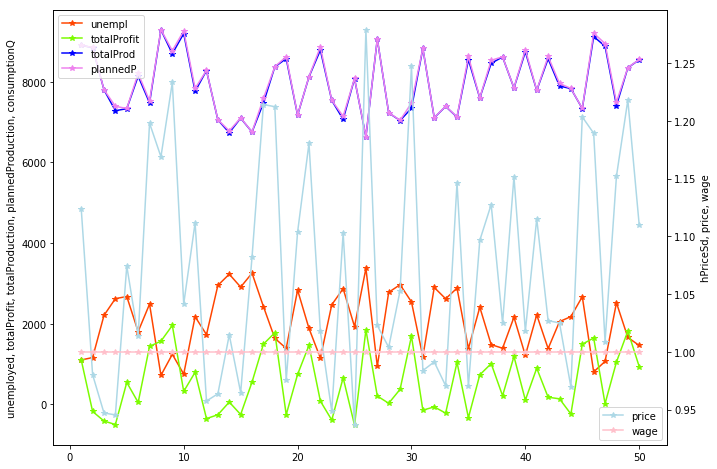

In [16]:
myPlot = ts_df.plot(figsize=(11,8),secondary_y=['hPriceSd', 'price','wage'],marker="*",
color=["OrangeRed","LawnGreen","Blue","Violet","lightblue","Pink","Gray","Brown"])
myPlot.set_ylabel('unemployed, totalProfit, totalProduction, plannedProduction, consumptionQ')
myPlot.right_ax.set_ylabel('hPriceSd, price, wage')
myPlot.legend(loc='upper left') #, bbox_to_anchor=(-0.35, 0.5)
myPlot.axes.right_ax.legend(loc='lower right') #, bbox_to_anchor=(1.1, 0.5)

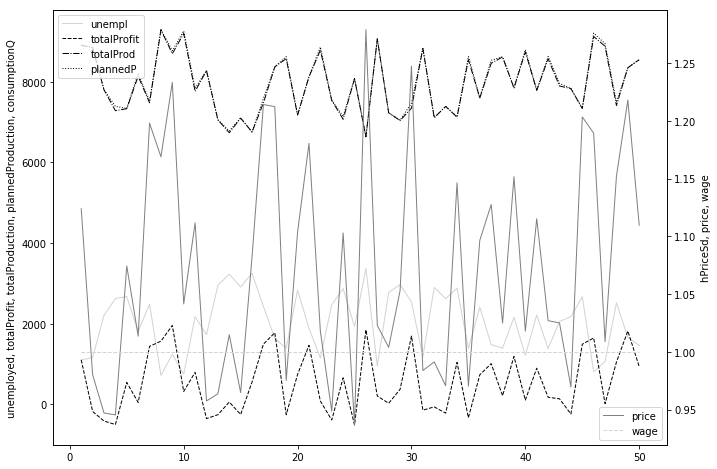

In [17]:
myPlot = ts_df.plot(figsize=(11,8),secondary_y=['hPriceSd', 'price','wage'],marker="",
color=["lightgray","Black","Black","Black","Gray","lightgray","lightgray","lightgray"],
style=['-', '--', '-.', ':','-', '--', '-.'],
linewidth=1.)
myPlot.set_ylabel('unemployed, totalProfit, totalProduction, plannedProduction, consumptionQ')
myPlot.right_ax.set_ylabel('hPriceSd, price, wage')
myPlot.legend(loc='upper left') #, bbox_to_anchor=(-0.35, 0.5)
myPlot.axes.right_ax.legend(loc='lower right') #, bbox_to_anchor=(1.1, 0.5)

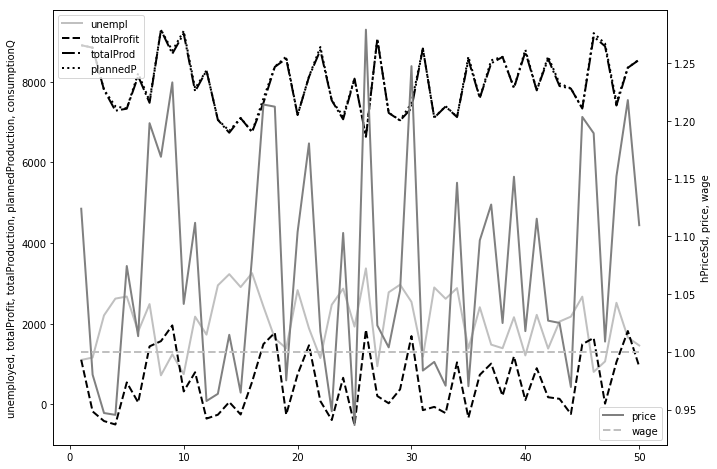

In [18]:
myPlot = ts_df.plot(figsize=(11,8),secondary_y=['hPriceSd', 'price','wage'],marker="",
color=["silver","Black","Black","Black","Gray","silver","silver","silver"],
style=['-', '--', '-.', ':','-', '--', '-.'],
linewidth=2.)
myPlot.set_ylabel('unemployed, totalProfit, totalProduction, plannedProduction, consumptionQ')
myPlot.right_ax.set_ylabel('hPriceSd, price, wage')
myPlot.legend(loc='upper left') #, bbox_to_anchor=(-0.35, 0.5)
myPlot.axes.right_ax.legend(loc='lower right') #, bbox_to_anchor=(1.1, 0.5)

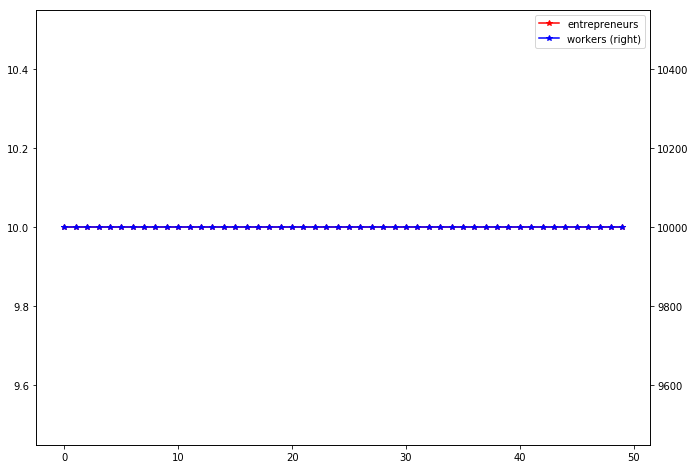

In [19]:
str_df.plot(figsize=(11,8),secondary_y='workers',marker="*",color=["r","b"])

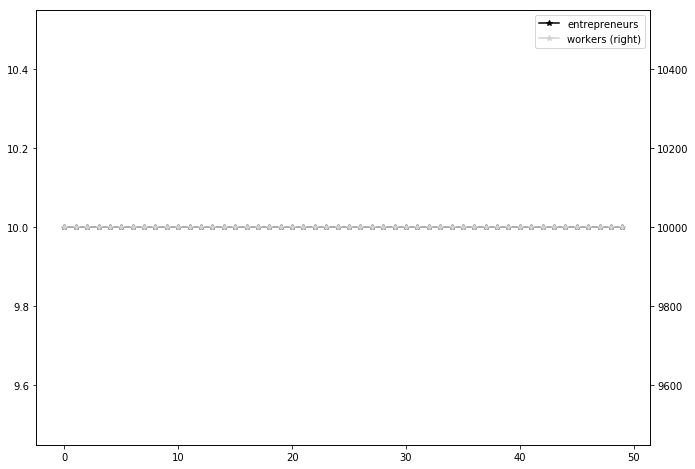

In [20]:
str_df.plot(figsize=(11,8),secondary_y='workers',marker="*",color=["black",
            "lightgrey"])

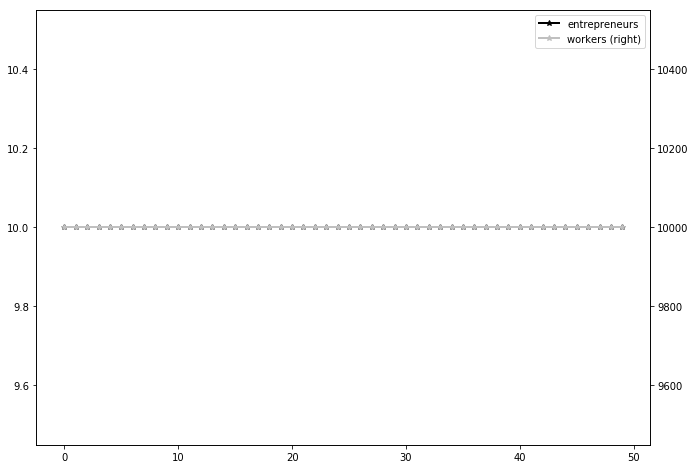

In [21]:
str_df.plot(figsize=(11,8),linewidth=2.0,secondary_y='workers',marker="*",color=["black",
            "silver"])

Best solutions to produce a LaTeX table from these data (the example is related to ts_df.corr table):

    corr=ts_df.corr(method='pearson')
    print corr.to_latex()
    
    "print" to have the output nicely formatted; copy and paste it to LaTeX and the 
    result works.
    
To output is included within:

    \begin{table}[htbp]
    
    ... output above ...
    
    \label{a label}
    \caption{a caption}
    \end{table}

We add also size specifications (\footnotesize in this case) and the usual [htbp] specification with \begin{table}[htbp]


Other solutions:
1. online [http://www.tablesgenerator.com](http://www.tablesgenerator.com), reading the csv file;
2. using a converter as [http://html2latex.sourceforge.net](http://html2latex.sourceforge.net).

## The first method is applied in the cells below.

In [22]:
corr=ts_df.corr(method='pearson')
def ff(x):
    return '%1.2f' % x
print ("\\begin{table}[!htbp]\n{\\footnotesize \center")
print (corr.to_latex(formatters=[ff,ff,ff,ff,ff,ff,ff,ff]))
print("}\n\\caption{Correlations among the time series of the model,"+\
      " with xxx}")
print("\\label{correlations xxx}\n\\end{table}")

\begin{table}[!htbp]
{\footnotesize \center
\begin{tabular}{lrrrrrr}
\toprule
{} & unempl & totalProfit & totalProd & plannedP & price & wage \\
\midrule
unempl      &   1.00 &       -0.02 &     -1.00 &    -1.00 &  0.05 &  nan \\
totalProfit &  -0.02 &        1.00 &      0.02 &     0.02 &  0.99 &  nan \\
totalProd   &  -1.00 &        0.02 &      1.00 &     1.00 & -0.05 &  nan \\
plannedP    &  -1.00 &        0.02 &      1.00 &     1.00 & -0.05 &  nan \\
price       &   0.05 &        0.99 &     -0.05 &    -0.05 &  1.00 &  nan \\
wage        &    nan &         nan &       nan &      nan &   nan &  nan \\
\bottomrule
\end{tabular}

}
\caption{Correlations among the time series of the model, with xxx}
\label{correlations xxx}
\end{table}


In [23]:
ou=out1
names=['unempl.','totalProfit','totalProd.','plannedP.','price','wage']
print ("\\begin{table}[!htbp]\n{\\footnotesize \center")
print ("\\begin{tabular}{lrrrrrr}\n\\toprule\n"+\
"{} & unempl. & totalProfit & totalProd. & plannedP. & price &  wage \\\\"+\
"\n\\midrule")
for i in range(len(ou)):
    print(names[i], end="")
    for j in range(len(ou[i])):
        print(" & %.2f" % ou[i,j], end="")
    print(" \\\\")
print("\\bottomrule\n\\end{tabular}")    
print("}\n\\caption{Partial correlations among the time series of the model,"+\
      " with xxx}")
print("\\label{partial correlations xxx}\n\\end{table}")

\begin{table}[!htbp]
{\footnotesize \center
\begin{tabular}{lrrrrrr}
\toprule
{} & unempl. & totalProfit & totalProd. & plannedP. & price &  wage \\
\midrule
unempl. & 1.00 & -0.04 & -0.20 & -1.00 & 0.05 & 0.00 \\
totalProfit & -0.04 & 1.00 & 0.51 & -0.06 & 1.00 & -0.05 \\
totalProd. & -0.20 & 0.51 & 1.00 & -0.17 & -0.52 & 0.07 \\
plannedP. & -1.00 & -0.06 & -0.17 & 1.00 & 0.07 & 0.00 \\
price & 0.05 & 1.00 & -0.52 & 0.07 & 1.00 & 0.13 \\
wage & 0.00 & -0.05 & 0.07 & 0.00 & 0.13 & 1.00 \\
\bottomrule
\end{tabular}
}
\caption{Partial correlations among the time series of the model, with xxx}
\label{partial correlations xxx}
\end{table}


In [24]:
ou=out2
names=['unempl.','totalProfit','totalProd.','price','wage']
print ("\\begin{table}[!htbp]\n{\\footnotesize \center")
print ("\\begin{tabular}{lrrrrrr}\n\\toprule\n"+\
"{} & unempl. & totalProfit & totalProd. & price &  wage \\\\"+\
"\n\\midrule")
for i in range(len(ou)):
    print(names[i], end="")
    for j in range(len(ou[i])):
        print(" & %.2f" % ou[i,j], end="")
    print(" \\\\")
print("\\bottomrule\n\\end{tabular}")    
print("}\n\\caption{Partial correlations (no plannedProduction) among the time series of the model,"+\
      " with xxx}")
print("\\label{partial correlations (no plannedP.) xxx}\n\\end{table}")

\begin{table}[!htbp]
{\footnotesize \center
\begin{tabular}{lrrrrrr}
\toprule
{} & unempl. & totalProfit & totalProd. & price &  wage \\
\midrule
unempl. & 1.00 & 0.51 & -1.00 & -0.52 & 0.00 \\
totalProfit & 0.51 & 1.00 & 0.53 & 1.00 & nan \\
totalProd. & -1.00 & 0.53 & 1.00 & -0.54 & -0.00 \\
price & -0.52 & 1.00 & -0.54 & 1.00 & nan \\
wage & 0.00 & nan & -0.00 & nan & 1.00 \\
\bottomrule
\end{tabular}
}
\caption{Partial correlations (no plannedProduction) among the time series of the model, with xxx}
\label{partial correlations (no plannedP.) xxx}
\end{table}


In [25]:
ou=out3
names=['unempl.','totalProfit','plannedP.','price','wage']
print ("\\begin{table}[!htbp]\n{\\footnotesize \center")
print ("\\begin{tabular}{lrrrrrr}\n\\toprule\n"+\
"{} & unempl. & totalProfit & plannedP. & price &  wage \\\\"+\
"\n\\midrule")
for i in range(len(ou)):
    print(names[i], end="")
    for j in range(len(ou[i])):
        print(" & %.2f" % ou[i,j], end="")
    print(" \\\\")
print("\\bottomrule\n\\end{tabular}")    
print("}\n\\caption{Partial correlations (no totalProduction) among the time series of the model,"+\
      " with xxx}")
print("\\label{partial correlations (no totalProd.) xxx}\n\\end{table}")

\begin{table}[!htbp]
{\footnotesize \center
\begin{tabular}{lrrrrrr}
\toprule
{} & unempl. & totalProfit & plannedP. & price &  wage \\
\midrule
unempl. & 1.00 & -0.17 & -1.00 & 0.18 & 0.00 \\
totalProfit & -0.17 & 1.00 & -0.17 & 0.99 & -0.14 \\
plannedP. & -1.00 & -0.17 & 1.00 & 0.18 & -0.00 \\
price & 0.18 & 0.99 & 0.18 & 1.00 & 0.07 \\
wage & 0.00 & -0.14 & -0.00 & 0.07 & 1.00 \\
\bottomrule
\end{tabular}
}
\caption{Partial correlations (no totalProduction) among the time series of the model, with xxx}
\label{partial correlations (no totalProd.) xxx}
\end{table}


## *Data from each firm in each period*

In [26]:
if firms: print(firms_df.describe())
else: print('no data for each firm in each period')

       production  profit
count      500.00  500.00
mean       794.43   54.32
std         85.49   75.98
min        608.16 -103.36
25%        731.00  -16.68
50%        791.00   36.15
75%        853.25  112.50
max        999.00  227.66
